In [1]:
import numpy as np
import torch
import pyepo

# set random seed
np.random.seed(42)
torch.manual_seed(42)

Auto-Sklearn cannot be imported.


## Data Set and Optimization Solver

In [2]:
# generate data
num_node = 20 # node size
num_data = 100 # number of training data
num_feat = 10 # size of feature
deg = 4 # polynomial degree
e = 0.5 # noise width
feats, costs = pyepo.data.tsp.genData(num_data+100+1000, num_feat, num_node, deg, e, seed=42)

In [3]:
from model import tspDFJModel
# set solver
optmodel = tspDFJModel(num_node)
# test
optmodel.setObj(costs[0])
sol, obj = optmodel.solve()
print("Obj: {}".format(obj))
tour = optmodel.getTour(sol)
print(" -> ".join(map(str, tour)))

Set parameter Username
Academic license - for non-commercial use only - expires 2024-01-01
Obj: 58.2849
0 -> 5 -> 3 -> 17 -> 1 -> 12 -> 4 -> 18 -> 9 -> 16 -> 7 -> 2 -> 14 -> 6 -> 13 -> 11 -> 19 -> 8 -> 15 -> 10 -> 0


In [4]:
# split data
from sklearn.model_selection import train_test_split
feats, x_test, costs, c_test = train_test_split(feats, costs, test_size=1000, random_state=42)
x_train, x_val, c_train, c_val = train_test_split(feats, costs, test_size=100, random_state=42)

In [5]:
# get training, validation and test dataset
dataset_train_cost = pyepo.data.dataset.optDataset(optmodel, x_train, costs=c_train)
dataset_val = pyepo.data.dataset.optDataset(optmodel, x_val, costs=c_val)
dataset_test = pyepo.data.dataset.optDataset(optmodel, x_test, costs=c_test)

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 146.02it/s]


Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 154.39it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 143.72it/s]


In [6]:
from dataset import optDatasetConstrs
dataset_train = optDatasetConstrs(optmodel, x_train, costs=c_train)

Optimizing for optDataset...


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 64.74it/s]


In [7]:
# get data loader
from torch.utils.data import DataLoader
from dataset import collate_fn
batch_size = 32
loader_train_cost = DataLoader(dataset_train_cost, batch_size=batch_size, shuffle=True)
loader_train = DataLoader(dataset_train, batch_size=batch_size, collate_fn=collate_fn, shuffle=True)
loader_val = DataLoader(dataset_val, batch_size=batch_size, collate_fn=collate_fn, shuffle=False)
loader_test = DataLoader(dataset_test, batch_size=batch_size, collate_fn=collate_fn, shuffle=False)

## Prediction Model

In [8]:
import torch
from torch import nn

# build linear model
class LinearRegression(nn.Module):

    def __init__(self):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(num_feat, num_node*(num_node-1)//2)

    def forward(self, x):
        out = self.linear(x)
        return out

## Plot 

In [9]:
from matplotlib import pyplot as plt

def plot(loss_log, grad_log, regret_log_trn, regret_log_val, num_epochs, log_step):
    # draw loss plot for training
    plt.figure(figsize=(16, 8))
    plt.plot(loss_log, color="c", lw=2)
    plt.xticks(fontsize=28)
    plt.yticks(fontsize=28)
    plt.xlabel("Iters", fontsize=36)
    plt.ylabel("Loss", fontsize=36)
    plt.title("Loss Curve on Training Set", fontsize=36)
    plt.show()
    # draw grad plot for training
    plt.figure(figsize=(16, 8))
    plt.plot(grad_log, color="g", alpha=0.5, lw=2)
    plt.xticks(fontsize=28)
    plt.yticks(fontsize=28)
    plt.gca().yaxis.get_offset_text().set_size(24)
    plt.xlabel("Iters", fontsize=36)
    plt.ylabel("Abs Grad", fontsize=36)
    plt.title("Absolute Gradient Curve on Training Set", fontsize=36)
    plt.show()
    # draw regret plot for test
    fig = plt.figure(figsize=(16, 8))
    plt.plot([i * log_step for i in range(len(regret_log_trn))], regret_log_trn,
             color="royalblue", ls="--", alpha=0.7, lw=5, label="Train")
    plt.plot([i * log_step for i in range(len(regret_log_val))], regret_log_val,
             color="lightcoral", ls=":", alpha=0.7, lw=5, label="Val")
    plt.xlim(-5, num_epochs+5)
    plt.ylim(0, 0.5)
    plt.xticks(range(0, num_epochs+1, 50), fontsize=28)
    plt.yticks(fontsize=28)
    plt.xlabel("Epoch", fontsize=36)
    plt.ylabel("Regret", fontsize=36)
    plt.legend(fontsize=32)
    plt.title("Regret Curve on Training and Validation Set", fontsize=36)
    plt.show()

## Train

In [10]:
num_epochs = 200
log_step = 10

In [11]:
import copy
import time
from tqdm import tqdm
import torch.nn.functional as F

from earlystop import earlyStopper
from clipgrad import clipGrad

def pipeline(reg, forward_func, loss_func, lr, num_epochs, 
             log_step, loader_train, loader_val, loader_test, grad_clip=False, seed=42):
    # set random seed
    np.random.seed(seed)
    torch.manual_seed(seed)
    # set optimizer
    optimizer = torch.optim.Adam(reg.parameters(), lr=lr)
    # set stopper
    stopper = earlyStopper(patience=3)
    stop = False
    # init best model
    best_model_state = copy.deepcopy(reg.state_dict())
    best_val_regret = float("inf")
    # init log
    loss_log = []
    grad_log = []
    regret_log_trn = []
    regret_log_val = []
    # running time
    elapsed = 0
    tbar = tqdm(range(num_epochs))
    for epoch in tbar:
        # eval & log
        if epoch % log_step == 0:
            # regret
            regret_trn = pyepo.metric.regret(reg, optmodel, loader_train_cost)
            regret_log_trn.append(regret_trn)
            regret_val = pyepo.metric.regret(reg, optmodel, loader_val)
            regret_log_val.append(regret_val)
            tbar.write("Epoch {:3}, Train Regret: {:8.4f}%, Val Regret: {:8.4f}%".format(epoch, regret_trn*100, regret_val*100))
            # update best model
            if regret_val < best_val_regret:
                best_val_regret = regret_val
                best_model_state = copy.deepcopy(reg.state_dict())
            # early stop
            if stopper.stop(regret_val):
                print()
                stop = True
                print("Early Stop!")
                break
        # training
        time.sleep(1)
        tick = time.time()
        for data in loader_train:
            # forward pass
            loss = forward_func(data, reg, loss_func, grad_log)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # clip
            if grad_clip:
                clipGrad(reg, threshold=1e-6)
            optimizer.step()
            loss_log.append(loss.item())
            tbar.set_description("Epoch {:4.0f}, Loss: {:8.4f}".format(epoch, loss.item()))
        # record time
        tock = time.time()
        elapsed += tock - tick
    # no early stop
    if not stop:
        regret_trn = pyepo.metric.regret(reg, optmodel, loader_train_cost)
        regret_log_trn.append(regret_trn)
        regret_val = pyepo.metric.regret(reg, optmodel, loader_val)
        regret_log_val.append(regret_val)
        tbar.write("Epoch {:3}, Train Regret: {:8.4f}%, Val Regret: {:8.4f}%".format(epoch, regret_trn*100, regret_val*100))
        # update best model
        if regret_val < best_val_regret:
            best_val_regret = regret_val
            best_model_state = copy.deepcopy(reg.state_dict())
    print("Training Elapsed Time: {:.2f} Sec".format(elapsed))
    # restore best model
    reg.load_state_dict(best_model_state)
    print()
    print("Evaluation:")
    tick = time.time()
    test_regret = pyepo.metric.regret(reg, optmodel, loader_test)
    tock = time.time()
    elapsed = tock - tick
    print("Test Regret: {:.4f}%".format(test_regret*100))
    print("Test Elapsed Time: {:.2f} Sec".format(elapsed))
    return loss_log, grad_log, regret_log_trn, regret_log_val

def forwardCAVE(data, reg, loss_func, grad_log, reg_lambda=1e-2):
    # unzip data
    x, c, _, t_ctr = data
    # predict
    cp = reg(x)
    # get gradient
    cp.register_hook(lambda grad: grad_log.append(abs(grad.cpu().detach().numpy()).sum()))
    # loss
    loss = loss_func(cp, t_ctr) + reg_lambda * F.mse_loss(cp, c)
    return loss

### Exact Method with Clarabel

In [12]:
# init model
reg = LinearRegression()

In [13]:
from func import exactConeAlignedCosine
# init loss
ca_cos = exactConeAlignedCosine(optmodel, solver="clarabel", processes=8)

(CVXPY) Dec 05 03:47:22 PM: Encountered unexpected exception importing solver OSQP:
ImportError('DLL load failed while importing qdldl: The specified module could not be found.')
Num of cores: 8


In [14]:
lr = 1e-1
loss_log, grad_log, regret_log_trn, regret_log_val = pipeline(reg, forwardCAVE, ca_cos, lr, num_epochs, log_step,
                                                              loader_train, loader_val, loader_test)

  0%|                                                                                          | 0/200 [00:01<?, ?it/s]

Epoch   0, Train Regret: 229.1573%, Val Regret: 226.7782%


Epoch    9, Loss:  -0.8246:   5%|██▋                                                  | 10/200 [00:20<04:12,  1.33s/it]

Epoch  10, Train Regret:  14.0162%, Val Regret:  18.7487%


Epoch   19, Loss:  -0.8836:  10%|█████▎                                               | 20/200 [00:34<03:52,  1.29s/it]

Epoch  20, Train Regret:  15.0899%, Val Regret:  16.5826%


Epoch   29, Loss:  -0.9304:  15%|███████▉                                             | 30/200 [00:48<03:37,  1.28s/it]

Epoch  30, Train Regret:  14.8948%, Val Regret:  15.9154%


Epoch   39, Loss:  -0.9332:  20%|██████████▌                                          | 40/200 [01:03<03:25,  1.29s/it]

Epoch  40, Train Regret:  14.2241%, Val Regret:  14.6657%


Epoch   49, Loss:  -0.8943:  25%|█████████████▎                                       | 50/200 [01:17<03:14,  1.30s/it]

Epoch  50, Train Regret:  14.0204%, Val Regret:  15.4284%


Epoch   59, Loss:  -0.9370:  30%|███████████████▉                                     | 60/200 [01:32<02:59,  1.28s/it]

Epoch  60, Train Regret:  13.8157%, Val Regret:  14.8729%


Epoch   69, Loss:  -0.9412:  35%|██████████████████▌                                  | 70/200 [01:46<03:17,  1.52s/it]


Epoch  70, Train Regret:  13.1633%, Val Regret:  15.1904%

Early Stop!
Training Elapsed Time: 22.10 Sec

Evaluation:
Test Regret: 15.4577%
Test Elapsed Time: 8.01 Sec


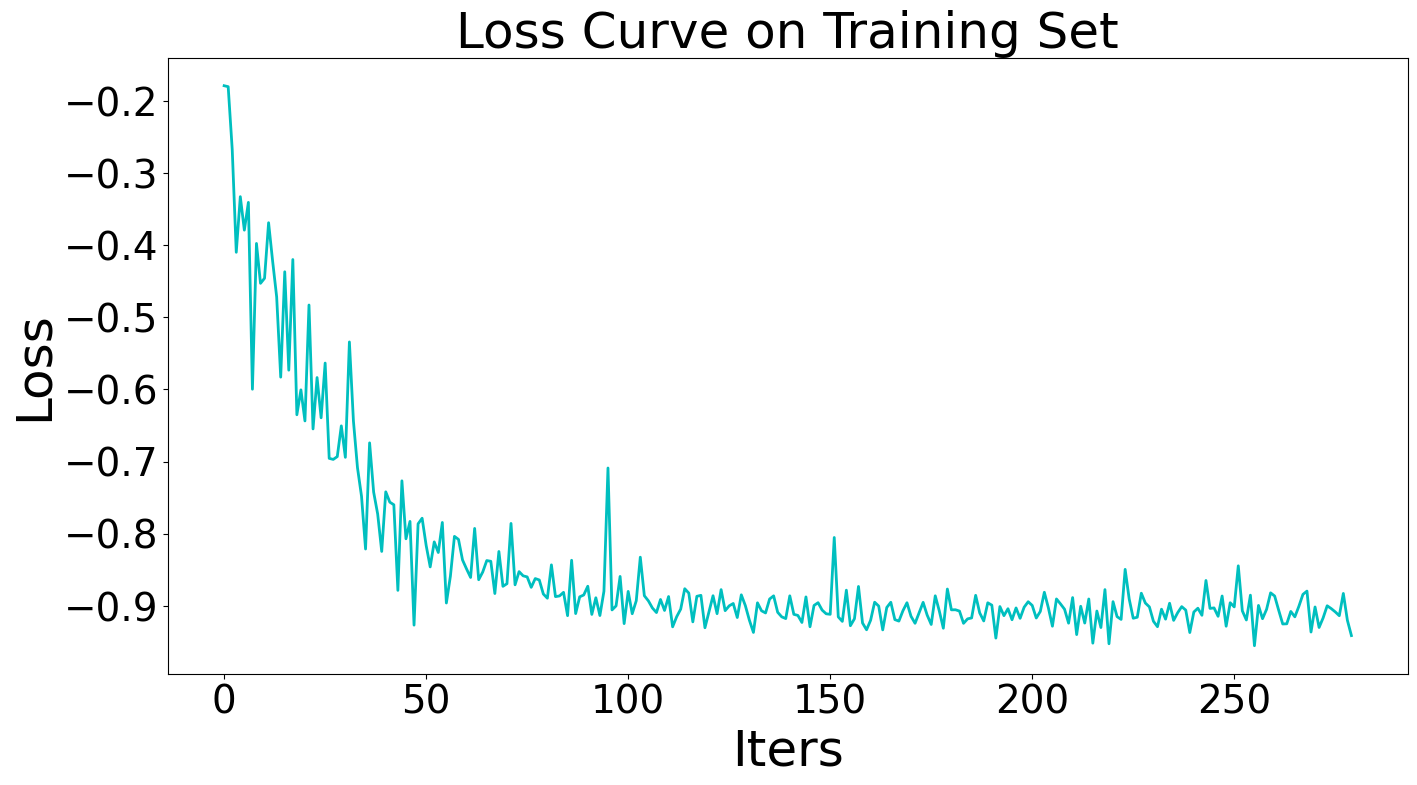

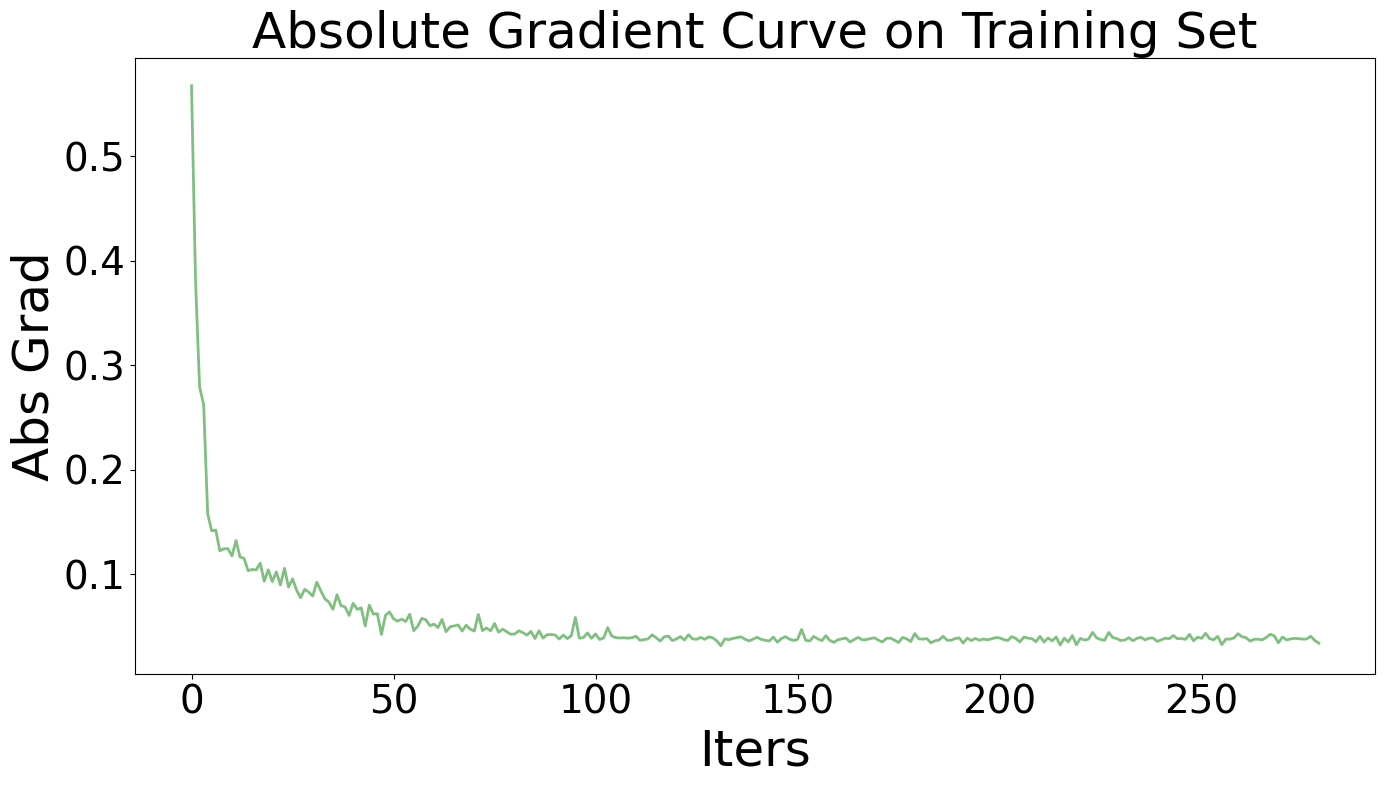

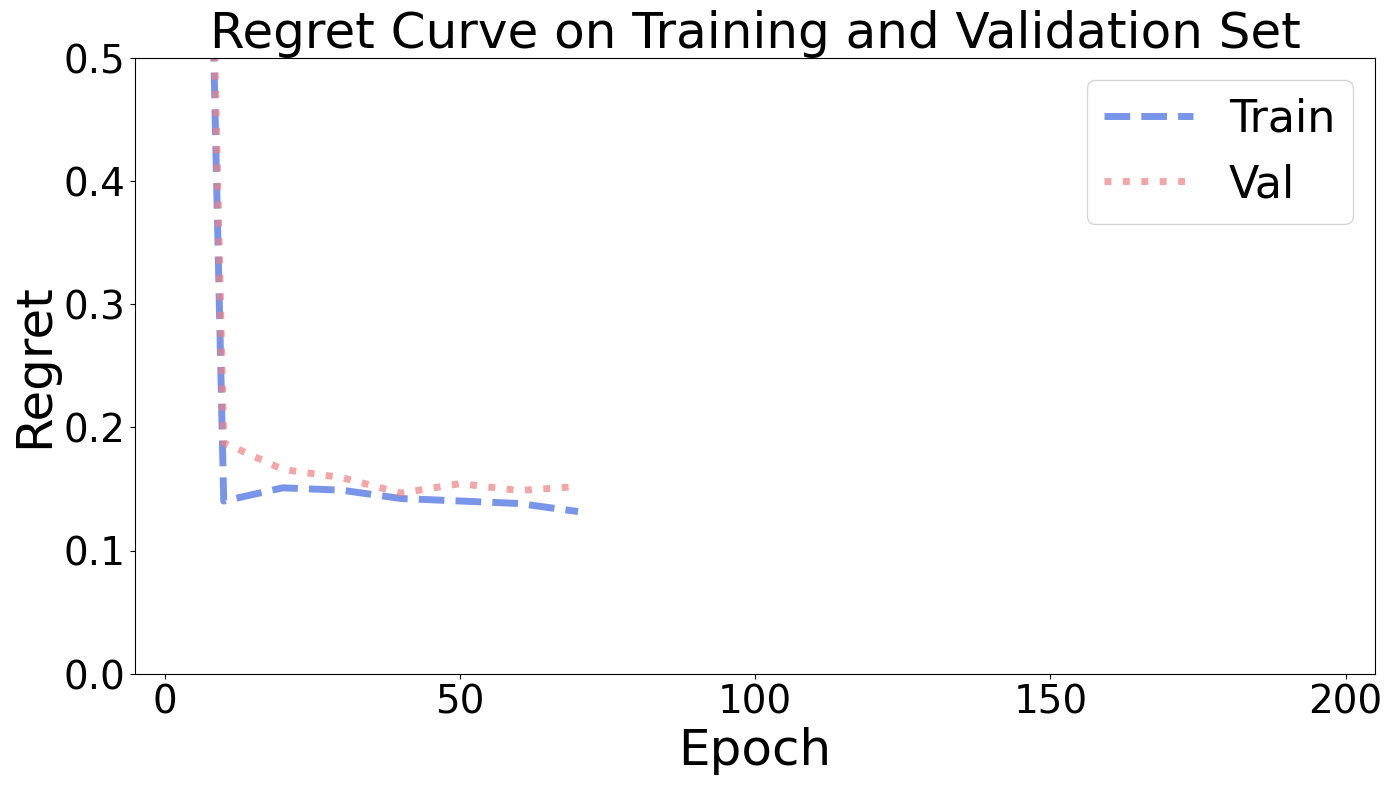

In [15]:
plot(loss_log, grad_log, regret_log_trn, regret_log_val, num_epochs, log_step)

### Inner Method with Clarabel

In [16]:
# init model
reg = LinearRegression()

In [17]:
from func import innerConeAlignedCosine
# init loss
ca_cos = innerConeAlignedCosine(optmodel, solver="clarabel", processes=8)

Num of cores: 8


In [18]:
lr = 1e-1
loss_log, grad_log, regret_log_trn, regret_log_val = pipeline(reg, forwardCAVE, ca_cos, lr, num_epochs, log_step,
                                                              loader_train, loader_val, loader_test)

  0%|                                                                                          | 0/200 [00:01<?, ?it/s]

Epoch   0, Train Regret: 213.6341%, Val Regret: 203.9659%


Epoch    9, Loss:  -0.8248:   5%|██▋                                                  | 10/200 [00:16<04:08,  1.31s/it]

Epoch  10, Train Regret:  13.7277%, Val Regret:  17.5303%


Epoch   19, Loss:  -0.8836:  10%|█████▎                                               | 20/200 [00:30<03:51,  1.28s/it]

Epoch  20, Train Regret:  15.0546%, Val Regret:  16.5336%


Epoch   29, Loss:  -0.9304:  15%|███████▉                                             | 30/200 [00:44<03:39,  1.29s/it]

Epoch  30, Train Regret:  14.2564%, Val Regret:  15.8168%


Epoch   39, Loss:  -0.9332:  20%|██████████▌                                          | 40/200 [00:58<03:24,  1.28s/it]

Epoch  40, Train Regret:  13.8797%, Val Regret:  14.7143%


Epoch   49, Loss:  -0.8942:  25%|█████████████▎                                       | 50/200 [01:13<03:13,  1.29s/it]

Epoch  50, Train Regret:  13.7616%, Val Regret:  15.1177%


Epoch   59, Loss:  -0.9368:  30%|███████████████▉                                     | 60/200 [01:27<02:59,  1.29s/it]

Epoch  60, Train Regret:  13.5727%, Val Regret:  14.7560%


Epoch   69, Loss:  -0.9411:  35%|██████████████████▌                                  | 70/200 [01:41<03:09,  1.46s/it]


Epoch  70, Train Regret:  12.9603%, Val Regret:  14.9731%

Early Stop!
Training Elapsed Time: 18.02 Sec

Evaluation:
Test Regret: 15.4862%
Test Elapsed Time: 8.24 Sec


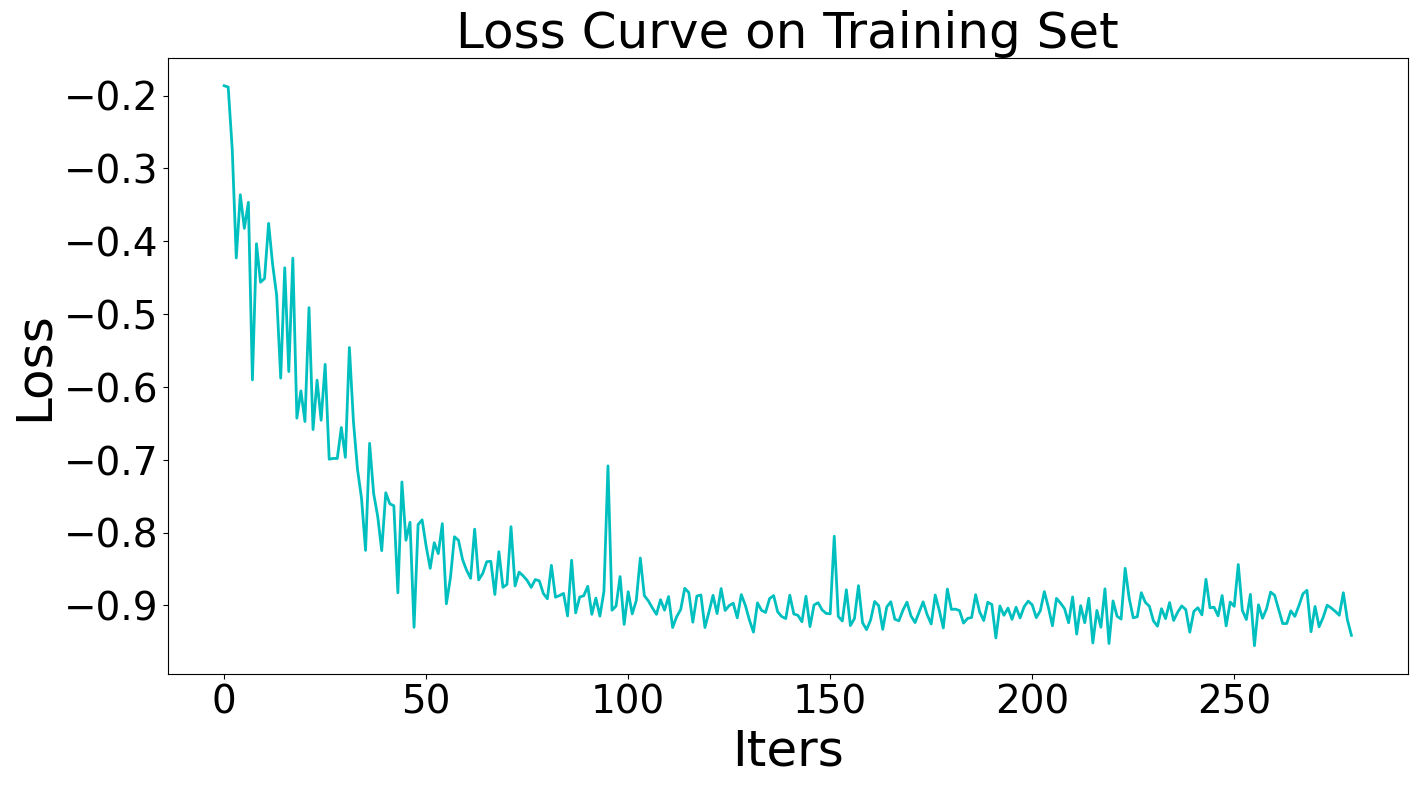

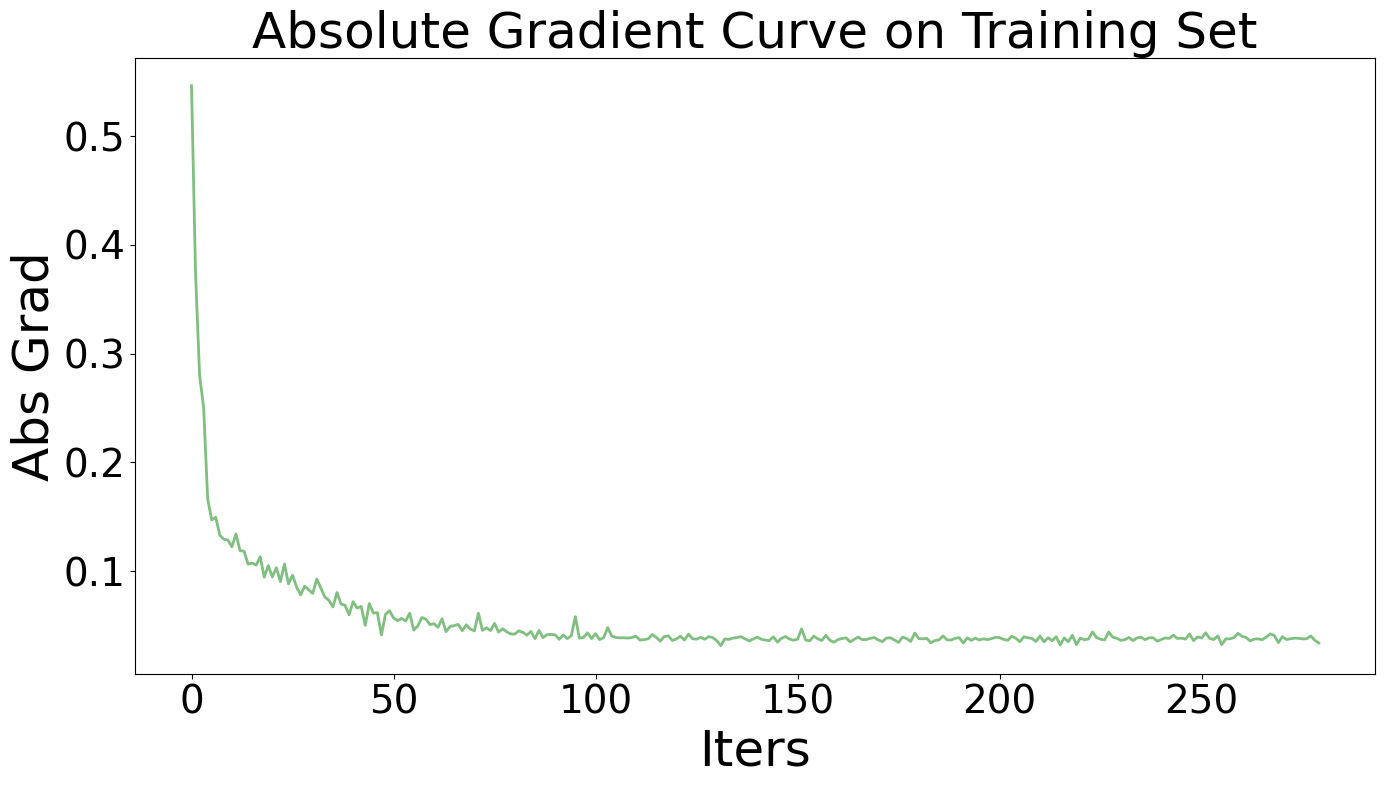

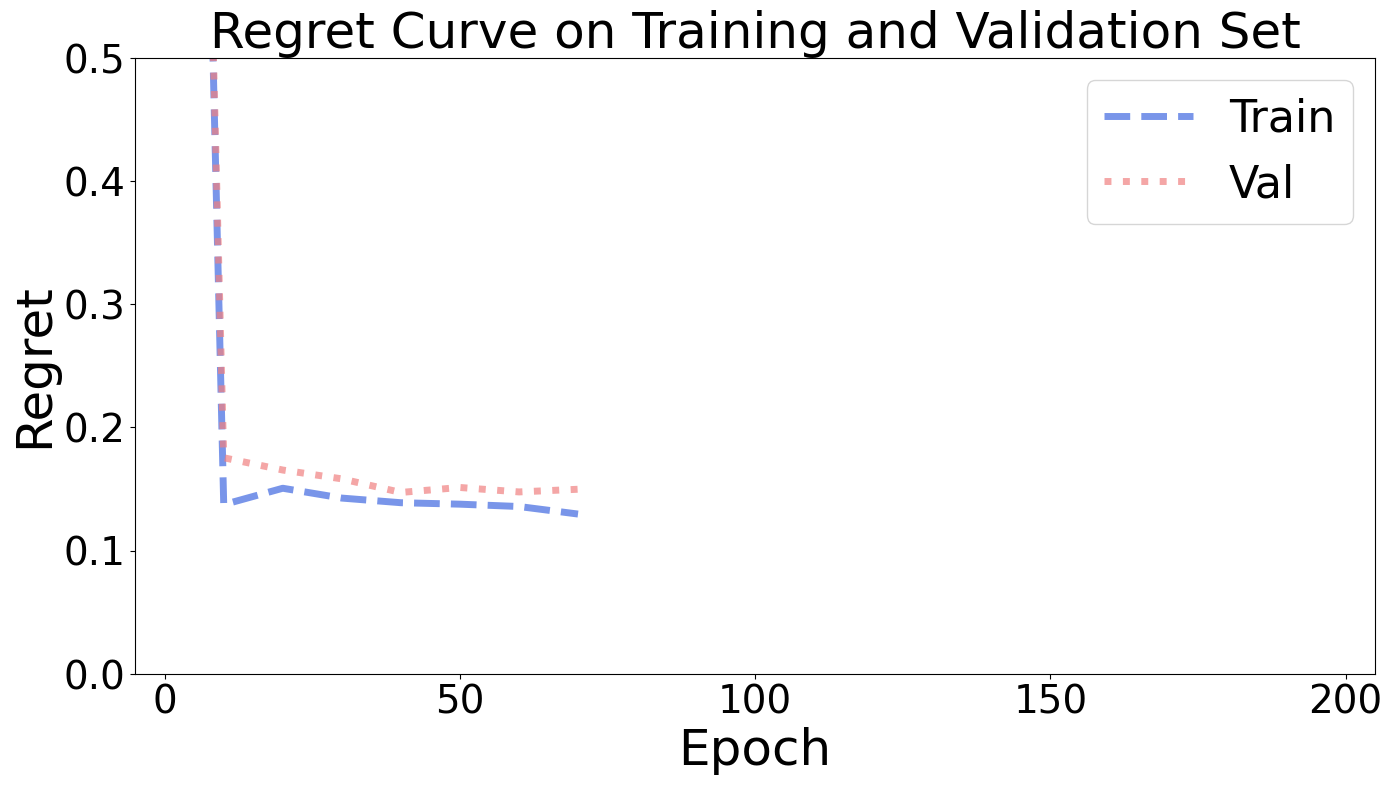

In [19]:
plot(loss_log, grad_log, regret_log_trn, regret_log_val, num_epochs, log_step)

###  Inner & Average Method

In [20]:
# init model
reg = LinearRegression()

In [21]:
from func import innerConeAlignedCosine
# init loss
ca_cos = innerConeAlignedCosine(optmodel, solver="clarabel", solve_ratio=0.3, processes=8)

Num of cores: 8


In [22]:
lr = 5e-2
loss_log, grad_log, regret_log_trn, regret_log_val = pipeline(reg, forwardCAVE, ca_cos, lr, num_epochs, log_step,
                                                              loader_train, loader_val, loader_test)

  0%|                                                                                          | 0/200 [00:01<?, ?it/s]

Epoch   0, Train Regret: 213.6341%, Val Regret: 203.9659%


Epoch    9, Loss:  -0.7141:   5%|██▋                                                  | 10/200 [00:14<03:35,  1.13s/it]

Epoch  10, Train Regret:  17.5794%, Val Regret:  23.2887%


Epoch   19, Loss:  -0.7990:  10%|█████▎                                               | 20/200 [00:27<03:24,  1.14s/it]

Epoch  20, Train Regret:  19.5988%, Val Regret:  21.6925%


Epoch   29, Loss:  -0.8642:  15%|███████▉                                             | 30/200 [00:39<03:11,  1.12s/it]

Epoch  30, Train Regret:  19.8690%, Val Regret:  21.5861%


Epoch   39, Loss:  -0.9209:  20%|██████████▌                                          | 40/200 [00:52<03:04,  1.15s/it]

Epoch  40, Train Regret:  19.0282%, Val Regret:  20.2174%


Epoch   49, Loss:  -0.8854:  25%|█████████████▎                                       | 50/200 [01:05<02:44,  1.10s/it]

Epoch  50, Train Regret:  17.2343%, Val Regret:  18.2276%


Epoch   59, Loss:  -0.9318:  30%|███████████████▉                                     | 60/200 [01:18<02:40,  1.15s/it]

Epoch  60, Train Regret:  16.3914%, Val Regret:  17.3573%


Epoch   69, Loss:  -0.9443:  35%|██████████████████▌                                  | 70/200 [01:30<02:20,  1.08s/it]

Epoch  70, Train Regret:  15.9291%, Val Regret:  16.9957%


Epoch   79, Loss:  -0.9166:  40%|█████████████████████▏                               | 80/200 [01:43<02:17,  1.15s/it]

Epoch  80, Train Regret:  15.1244%, Val Regret:  16.4855%


Epoch   89, Loss:  -0.9519:  45%|███████████████████████▊                             | 90/200 [01:55<02:03,  1.12s/it]

Epoch  90, Train Regret:  15.9296%, Val Regret:  16.9426%


Epoch   99, Loss:  -0.9097:  50%|██████████████████████████                          | 100/200 [02:08<01:48,  1.08s/it]

Epoch 100, Train Regret:  15.3421%, Val Regret:  15.9648%


Epoch  109, Loss:  -0.9380:  55%|████████████████████████████▌                       | 110/200 [02:20<01:42,  1.14s/it]

Epoch 110, Train Regret:  14.7875%, Val Regret:  16.5439%


Epoch  119, Loss:  -0.8665:  60%|███████████████████████████████▏                    | 120/200 [02:33<01:31,  1.15s/it]

Epoch 120, Train Regret:  14.4277%, Val Regret:  15.4353%


Epoch  129, Loss:  -0.9442:  65%|█████████████████████████████████▊                  | 130/200 [02:46<01:16,  1.09s/it]

Epoch 130, Train Regret:  14.3603%, Val Regret:  15.7113%


Epoch  139, Loss:  -0.9292:  70%|████████████████████████████████████▍               | 140/200 [02:58<01:06,  1.11s/it]

Epoch 140, Train Regret:  14.5634%, Val Regret:  14.9359%


Epoch  149, Loss:  -0.8799:  75%|███████████████████████████████████████             | 150/200 [03:11<00:58,  1.16s/it]

Epoch 150, Train Regret:  14.3863%, Val Regret:  14.5106%


Epoch  159, Loss:  -0.8258:  80%|█████████████████████████████████████████▌          | 160/200 [03:24<00:46,  1.17s/it]

Epoch 160, Train Regret:  14.2726%, Val Regret:  15.3758%


Epoch  169, Loss:  -0.9275:  85%|████████████████████████████████████████████▏       | 170/200 [03:37<00:34,  1.16s/it]

Epoch 170, Train Regret:  14.8620%, Val Regret:  15.2583%


Epoch  179, Loss:  -0.9475:  90%|██████████████████████████████████████████████▊     | 180/200 [03:50<00:25,  1.28s/it]


Epoch 180, Train Regret:  13.2498%, Val Regret:  15.6051%

Early Stop!
Training Elapsed Time: 17.76 Sec

Evaluation:
Test Regret: 15.9955%
Test Elapsed Time: 8.32 Sec


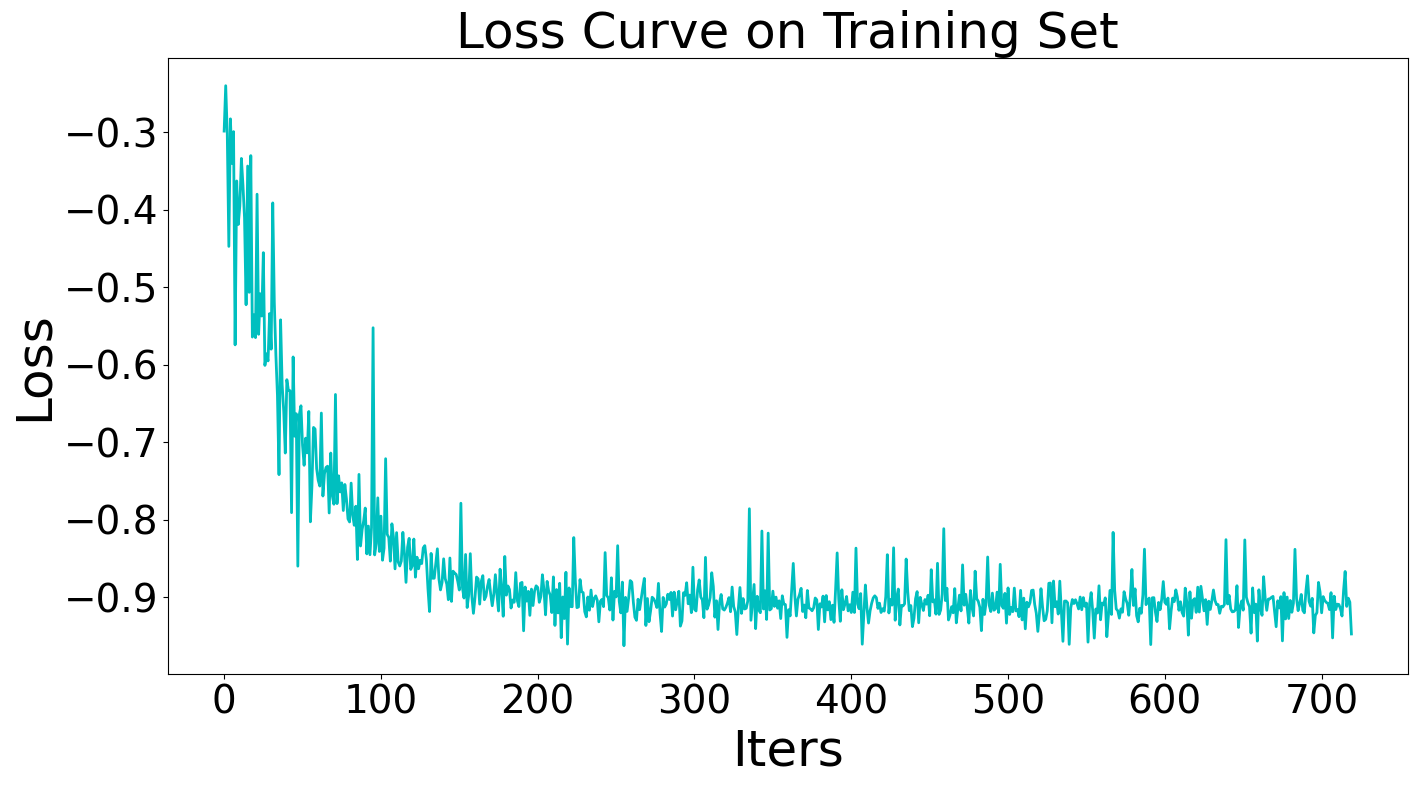

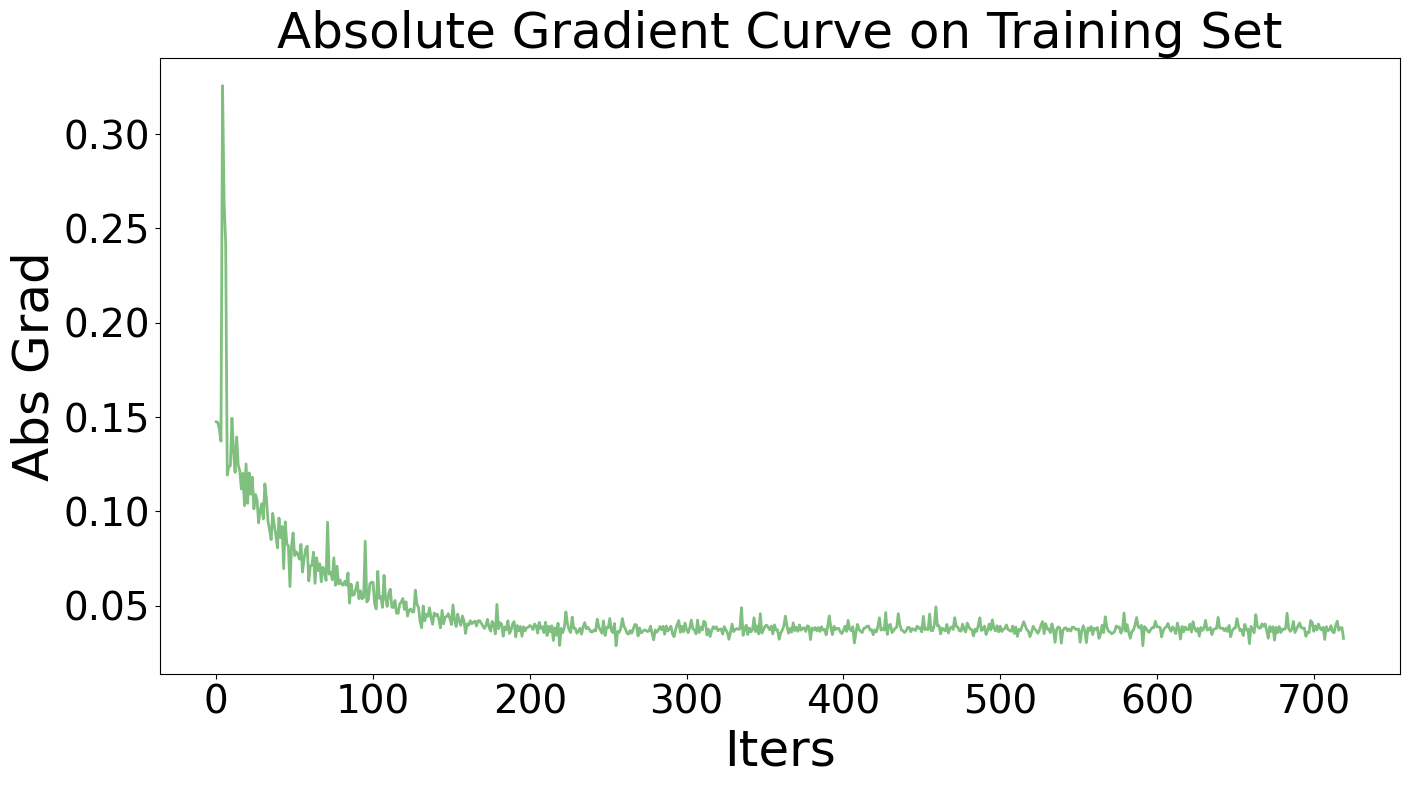

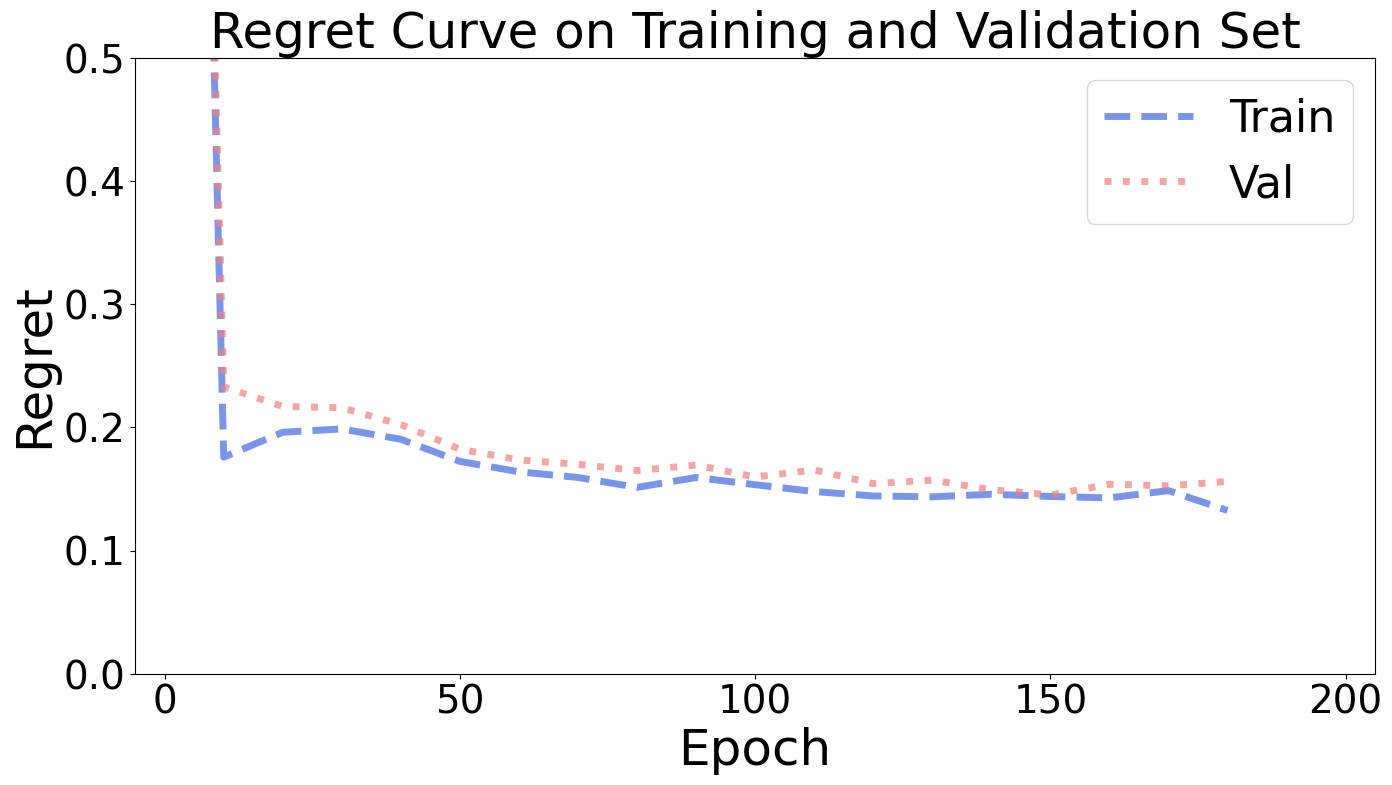

In [23]:
plot(loss_log, grad_log, regret_log_trn, regret_log_val, num_epochs, log_step)

### Sampling Method

In [24]:
# init model
reg = LinearRegression()

In [25]:
from func import samplingConeAlignedCosine
# init loss
ca_cos = samplingConeAlignedCosine(optmodel, n_samples=100, inner_ratio=0.4)

Num of cores: 1


In [26]:
lr = 1e-1
loss_log, grad_log, regret_log_trn, regret_log_val = pipeline(reg, forwardCAVE, ca_cos, lr, num_epochs, log_step,
                                                              loader_train, loader_val, loader_test)

  0%|                                                                                          | 0/200 [00:01<?, ?it/s]

Epoch   0, Train Regret: 199.3609%, Val Regret: 185.2989%


Epoch    9, Loss:  -0.6219:   5%|██▋                                                  | 10/200 [00:14<03:29,  1.10s/it]

Epoch  10, Train Regret:  20.7367%, Val Regret:  23.3548%


Epoch   19, Loss:  -0.9227:  10%|█████▎                                               | 20/200 [00:26<03:17,  1.10s/it]

Epoch  20, Train Regret:  18.6296%, Val Regret:  20.5109%


Epoch   29, Loss:  -0.7866:  15%|███████▉                                             | 30/200 [00:38<03:06,  1.10s/it]

Epoch  30, Train Regret:  15.8778%, Val Regret:  17.7752%


Epoch   39, Loss:  -0.9423:  20%|██████████▌                                          | 40/200 [00:51<02:55,  1.10s/it]

Epoch  40, Train Regret:  14.5972%, Val Regret:  15.6315%


Epoch   49, Loss:  -0.9121:  25%|█████████████▎                                       | 50/200 [01:03<02:44,  1.10s/it]

Epoch  50, Train Regret:  13.9655%, Val Regret:  16.0999%


Epoch   59, Loss:  -0.8621:  30%|███████████████▉                                     | 60/200 [01:15<02:33,  1.09s/it]

Epoch  60, Train Regret:  14.9293%, Val Regret:  15.6333%


Epoch   69, Loss:  -0.9020:  35%|██████████████████▌                                  | 70/200 [01:28<02:22,  1.10s/it]

Epoch  70, Train Regret:  13.4177%, Val Regret:  15.0223%


Epoch   79, Loss:  -0.9054:  40%|█████████████████████▏                               | 80/200 [01:40<02:11,  1.10s/it]

Epoch  80, Train Regret:  14.5976%, Val Regret:  15.0164%


Epoch   89, Loss:  -0.9033:  45%|███████████████████████▊                             | 90/200 [01:53<02:00,  1.10s/it]

Epoch  90, Train Regret:  14.1292%, Val Regret:  15.4959%


Epoch   99, Loss:  -0.8033:  50%|██████████████████████████                          | 100/200 [02:05<02:05,  1.26s/it]


Epoch 100, Train Regret:  15.2962%, Val Regret:  16.1861%

Early Stop!
Training Elapsed Time: 6.97 Sec

Evaluation:
Test Regret: 15.7767%
Test Elapsed Time: 9.25 Sec


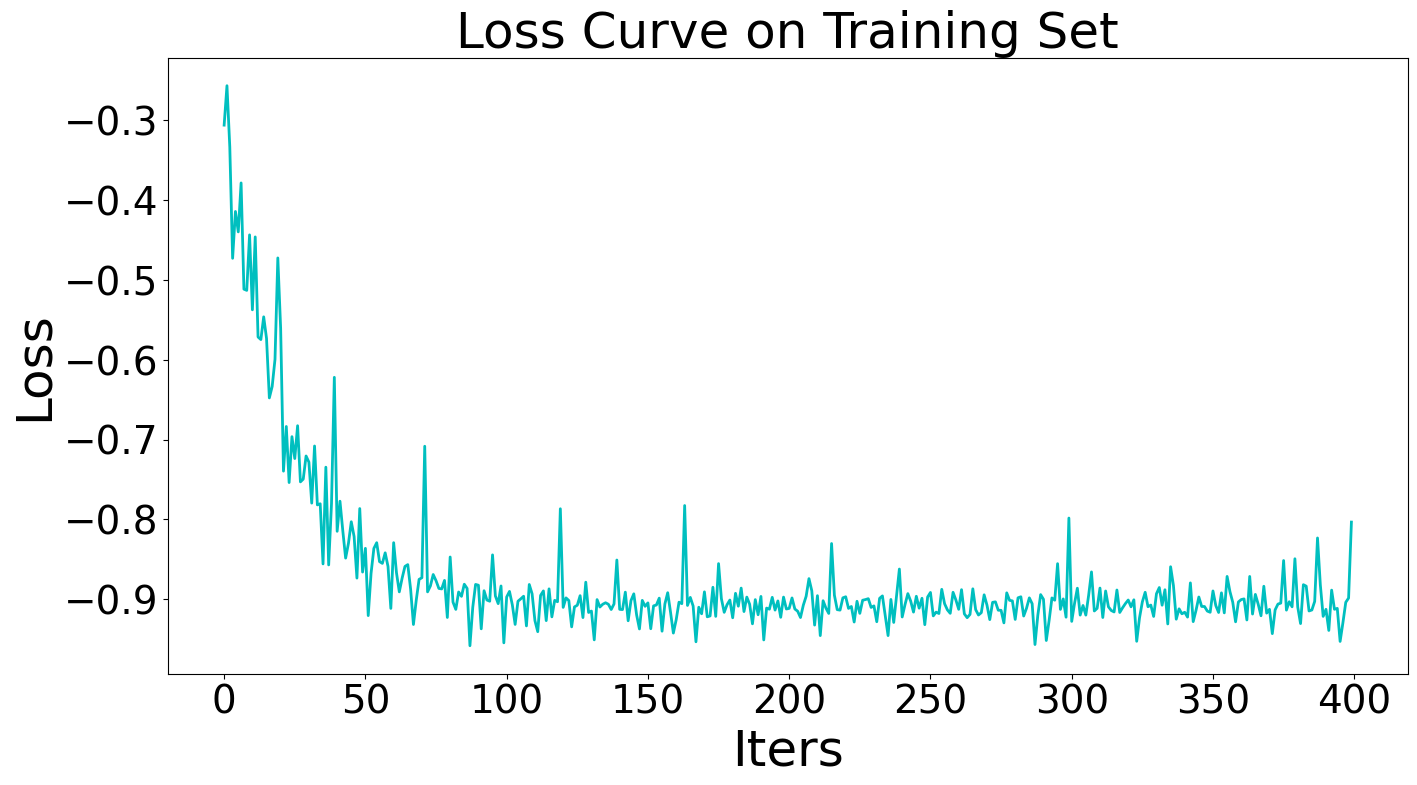

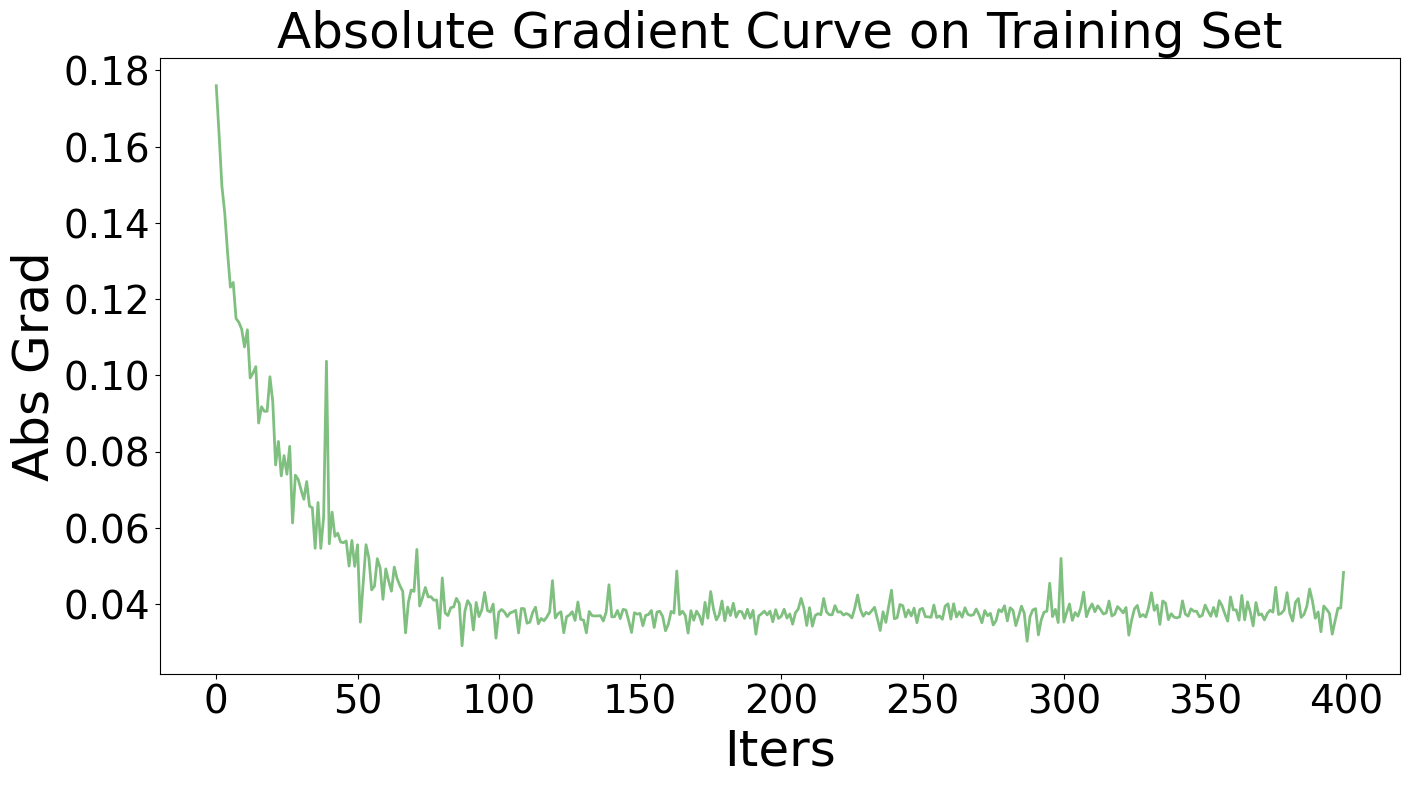

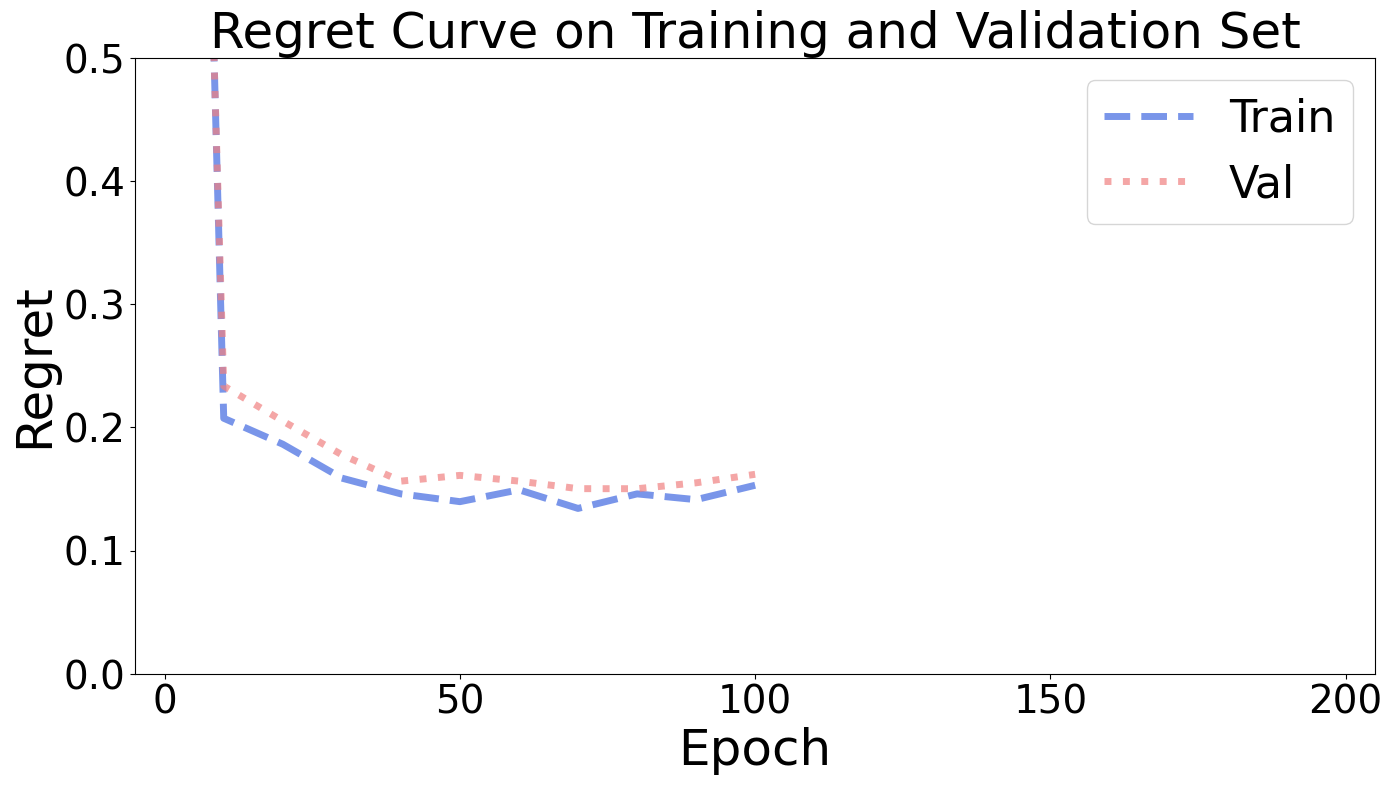

In [27]:
plot(loss_log, grad_log, regret_log_trn, regret_log_val, num_epochs, log_step)

### Sampling Method with Cone Check

In [28]:
# init model
reg = LinearRegression()

In [29]:
from func import samplingConeAlignedCosine
# init loss
ca_cos = samplingConeAlignedCosine(optmodel, n_samples=100, inner_ratio=0.4, check_cone=True, processes=8)

Num of cores: 8


In [30]:
lr = 1e-1
loss_log, grad_log, regret_log_trn, regret_log_val = pipeline(reg, forwardCAVE, ca_cos, lr, num_epochs, log_step,
                                                              loader_train, loader_val, loader_test)

  0%|                                                                                          | 0/200 [00:01<?, ?it/s]

Epoch   0, Train Regret: 208.8140%, Val Regret: 200.5503%


Epoch    9, Loss:  -0.6187:   5%|██▋                                                  | 10/200 [00:22<05:57,  1.88s/it]

Epoch  10, Train Regret:  20.4707%, Val Regret:  23.4693%


Epoch   19, Loss:  -0.9222:  10%|█████▎                                               | 20/200 [00:42<05:31,  1.84s/it]

Epoch  20, Train Regret:  18.5450%, Val Regret:  21.4529%


Epoch   29, Loss:  -0.7865:  15%|███████▉                                             | 30/200 [01:02<05:16,  1.86s/it]

Epoch  30, Train Regret:  16.1203%, Val Regret:  17.6517%


Epoch   39, Loss:  -0.9423:  20%|██████████▌                                          | 40/200 [01:22<04:59,  1.87s/it]

Epoch  40, Train Regret:  14.3006%, Val Regret:  15.7279%


Epoch   49, Loss:  -0.9122:  25%|█████████████▎                                       | 50/200 [01:42<04:38,  1.85s/it]

Epoch  50, Train Regret:  14.0409%, Val Regret:  16.2347%


Epoch   59, Loss:  -0.8620:  30%|███████████████▉                                     | 60/200 [02:02<04:22,  1.88s/it]

Epoch  60, Train Regret:  14.9429%, Val Regret:  15.5246%


Epoch   69, Loss:  -0.9020:  35%|██████████████████▌                                  | 70/200 [02:22<03:57,  1.83s/it]

Epoch  70, Train Regret:  13.5205%, Val Regret:  15.0374%


Epoch   79, Loss:  -0.9054:  40%|█████████████████████▏                               | 80/200 [02:42<03:40,  1.83s/it]

Epoch  80, Train Regret:  14.5433%, Val Regret:  15.0646%


Epoch   89, Loss:  -0.9032:  45%|███████████████████████▊                             | 90/200 [03:02<03:26,  1.87s/it]

Epoch  90, Train Regret:  14.0808%, Val Regret:  15.4583%


Epoch   99, Loss:  -0.8033:  50%|██████████████████████████                          | 100/200 [03:22<03:22,  2.02s/it]


Epoch 100, Train Regret:  15.3231%, Val Regret:  16.2077%

Early Stop!
Training Elapsed Time: 82.96 Sec

Evaluation:
Test Regret: 15.5586%
Test Elapsed Time: 8.30 Sec


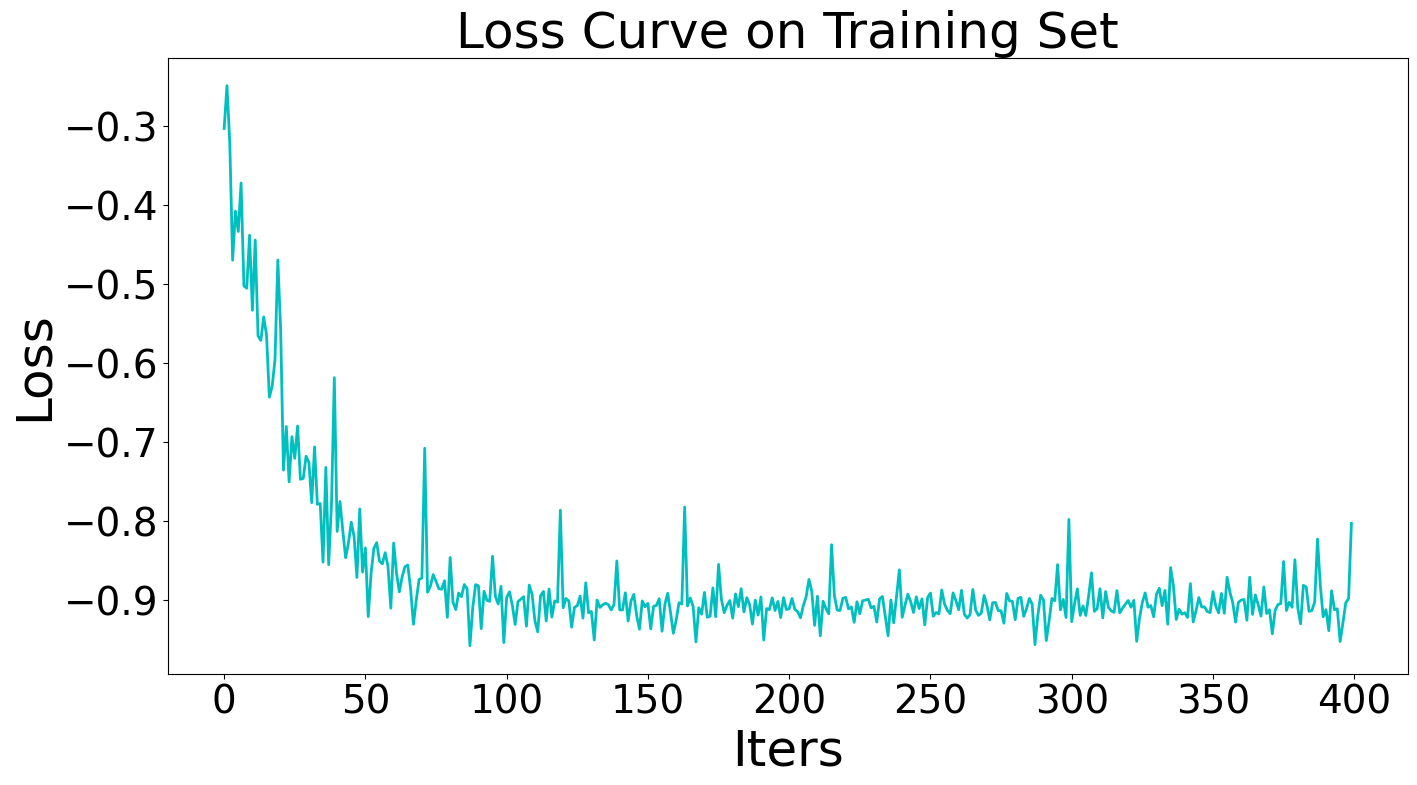

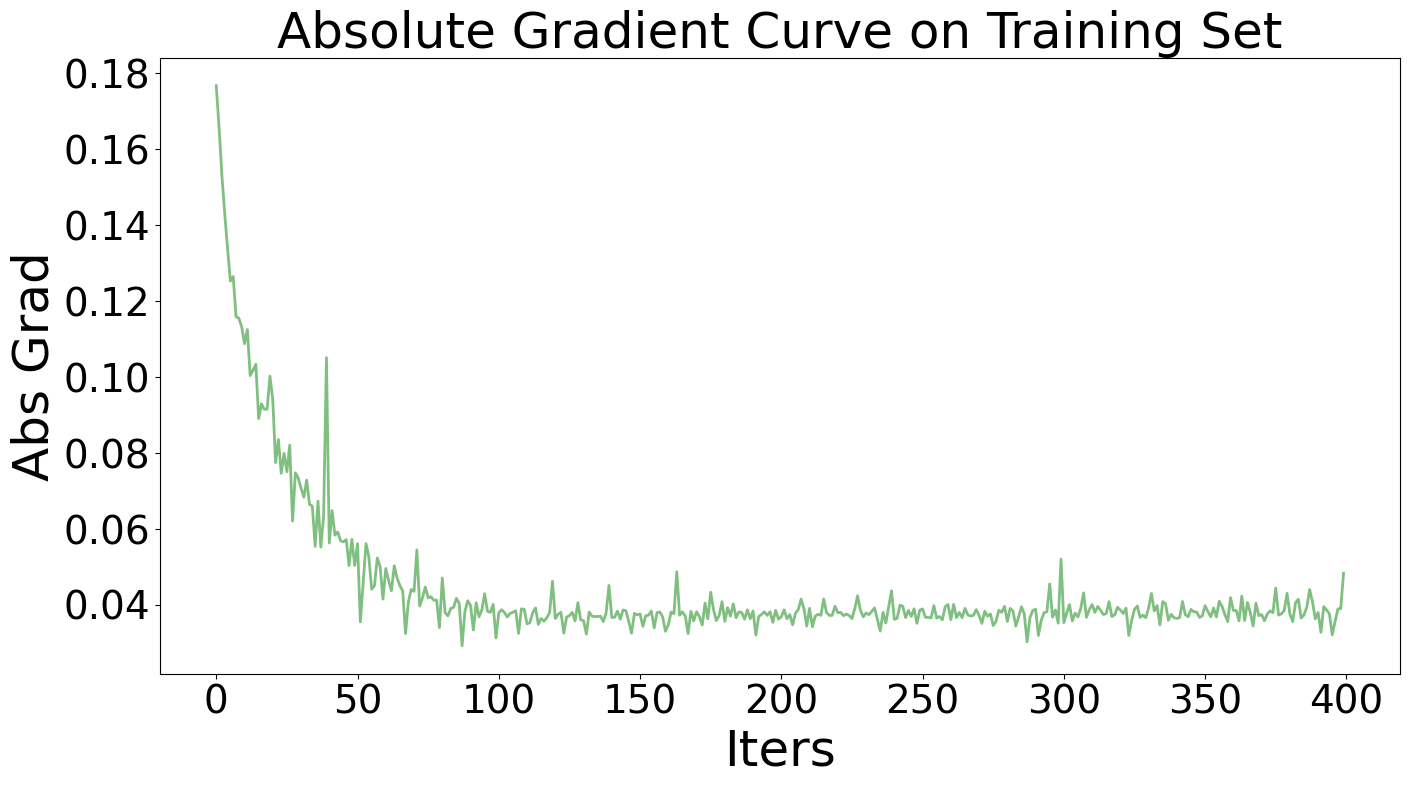

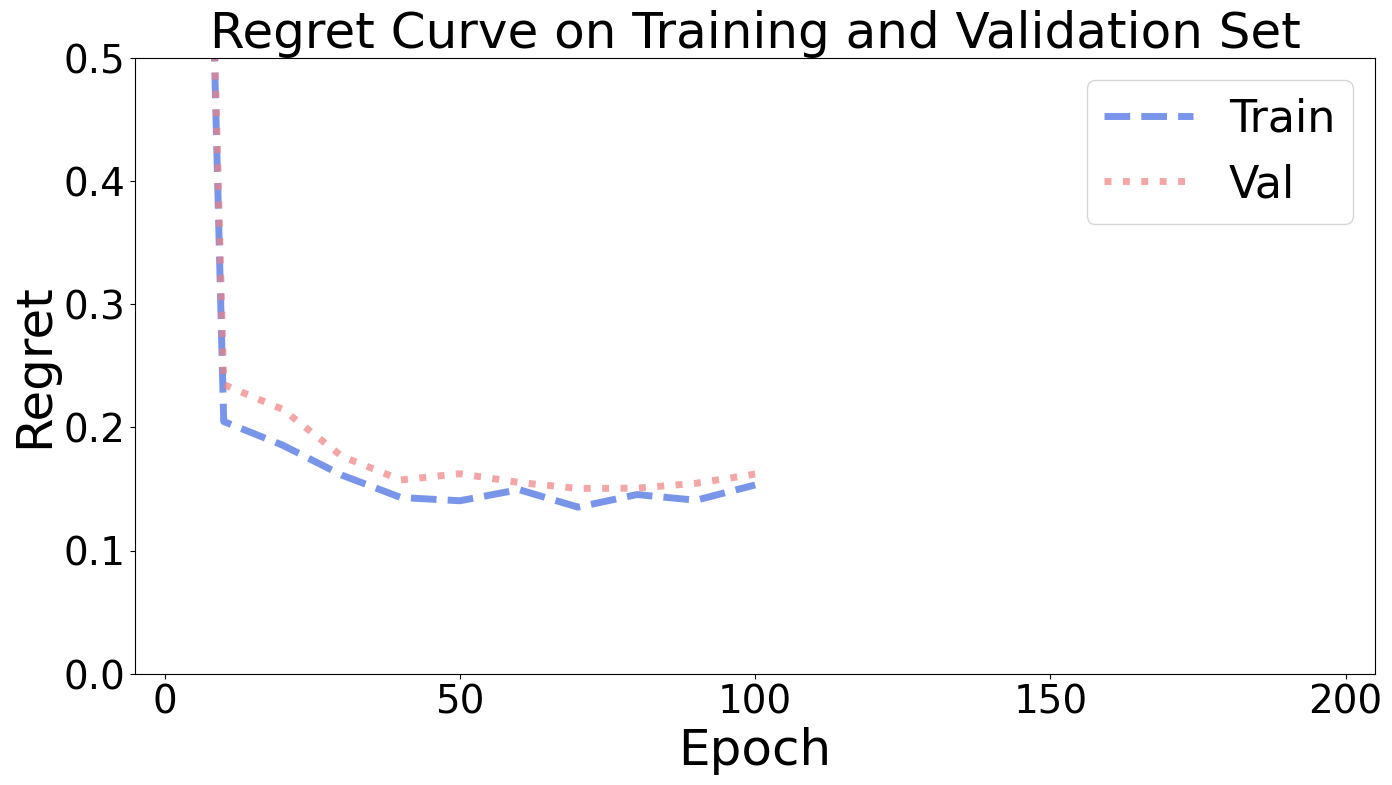

In [31]:
plot(loss_log, grad_log, regret_log_trn, regret_log_val, num_epochs, log_step)

### Average Method 

In [32]:
# init model
reg = LinearRegression()

In [33]:
from func import avgConeAlignedCosine
# init loss
ca_cos = avgConeAlignedCosine(optmodel, inner_ratio=0.4)

Num of cores: 1


In [34]:
lr = 1e-1
loss_log, grad_log, regret_log_trn, regret_log_val = pipeline(reg, forwardCAVE, ca_cos, lr, num_epochs, log_step,
                                                              loader_train, loader_val, loader_test)

  0%|                                                                                          | 0/200 [00:01<?, ?it/s]

Epoch   0, Train Regret: 208.8140%, Val Regret: 200.5503%


Epoch    9, Loss:  -0.8585:   5%|██▋                                                  | 10/200 [00:13<03:19,  1.05s/it]

Epoch  10, Train Regret:  21.2413%, Val Regret:  22.0089%


Epoch   19, Loss:  -0.8916:  10%|█████▎                                               | 20/200 [00:25<03:09,  1.05s/it]

Epoch  20, Train Regret:  18.3905%, Val Regret:  20.8356%


Epoch   29, Loss:  -0.9342:  15%|███████▉                                             | 30/200 [00:37<02:58,  1.05s/it]

Epoch  30, Train Regret:  16.7768%, Val Regret:  17.3302%


Epoch   39, Loss:  -0.9327:  20%|██████████▌                                          | 40/200 [00:49<02:47,  1.05s/it]

Epoch  40, Train Regret:  14.1960%, Val Regret:  15.9453%


Epoch   49, Loss:  -0.8949:  25%|█████████████▎                                       | 50/200 [01:01<02:37,  1.05s/it]

Epoch  50, Train Regret:  14.2918%, Val Regret:  15.8094%


Epoch   59, Loss:  -0.9369:  30%|███████████████▉                                     | 60/200 [01:13<02:27,  1.05s/it]

Epoch  60, Train Regret:  14.4145%, Val Regret:  15.6452%


Epoch   69, Loss:  -0.9411:  35%|██████████████████▌                                  | 70/200 [01:25<02:16,  1.05s/it]

Epoch  70, Train Regret:  13.2869%, Val Regret:  15.5023%


Epoch   79, Loss:  -0.9190:  40%|█████████████████████▏                               | 80/200 [01:37<02:05,  1.05s/it]

Epoch  80, Train Regret:  14.8191%, Val Regret:  16.4243%


Epoch   89, Loss:  -0.9452:  45%|███████████████████████▊                             | 90/200 [01:49<01:55,  1.05s/it]

Epoch  90, Train Regret:  15.2101%, Val Regret:  16.6906%


Epoch   99, Loss:  -0.9114:  50%|██████████████████████████                          | 100/200 [02:01<01:45,  1.05s/it]

Epoch 100, Train Regret:  14.0431%, Val Regret:  15.4644%


Epoch  109, Loss:  -0.9339:  55%|████████████████████████████▌                       | 110/200 [02:13<01:34,  1.05s/it]

Epoch 110, Train Regret:  15.1636%, Val Regret:  15.9004%


Epoch  119, Loss:  -0.8595:  60%|███████████████████████████████▏                    | 120/200 [02:25<01:24,  1.05s/it]

Epoch 120, Train Regret:  14.1909%, Val Regret:  15.5115%


Epoch  129, Loss:  -0.9464:  65%|█████████████████████████████████▊                  | 130/200 [02:37<01:13,  1.05s/it]

Epoch 130, Train Regret:  14.3130%, Val Regret:  15.1589%


Epoch  139, Loss:  -0.9314:  70%|████████████████████████████████████▍               | 140/200 [02:49<01:02,  1.05s/it]

Epoch 140, Train Regret:  13.9582%, Val Regret:  14.9410%


Epoch  149, Loss:  -0.8800:  75%|███████████████████████████████████████             | 150/200 [03:01<00:52,  1.05s/it]

Epoch 150, Train Regret:  14.9054%, Val Regret:  14.9222%


Epoch  159, Loss:  -0.8142:  80%|█████████████████████████████████████████▌          | 160/200 [03:13<00:42,  1.05s/it]

Epoch 160, Train Regret:  14.3196%, Val Regret:  15.3255%


Epoch  169, Loss:  -0.9300:  85%|████████████████████████████████████████████▏       | 170/200 [03:25<00:31,  1.05s/it]

Epoch 170, Train Regret:  14.6259%, Val Regret:  15.4695%


Epoch  179, Loss:  -0.9433:  90%|██████████████████████████████████████████████▊     | 180/200 [03:37<00:21,  1.05s/it]

Epoch 180, Train Regret:  13.7843%, Val Regret:  14.7263%


Epoch  189, Loss:  -0.9271:  95%|█████████████████████████████████████████████████▍  | 190/200 [03:49<00:10,  1.05s/it]

Epoch 190, Train Regret:  13.2778%, Val Regret:  15.1750%


Epoch  199, Loss:  -0.8740: 100%|████████████████████████████████████████████████████| 200/200 [03:59<00:00,  1.20s/it]


Epoch 199, Train Regret:  14.4367%, Val Regret:  15.1565%
Training Elapsed Time: 4.74 Sec

Evaluation:
Test Regret: 15.6024%
Test Elapsed Time: 8.24 Sec


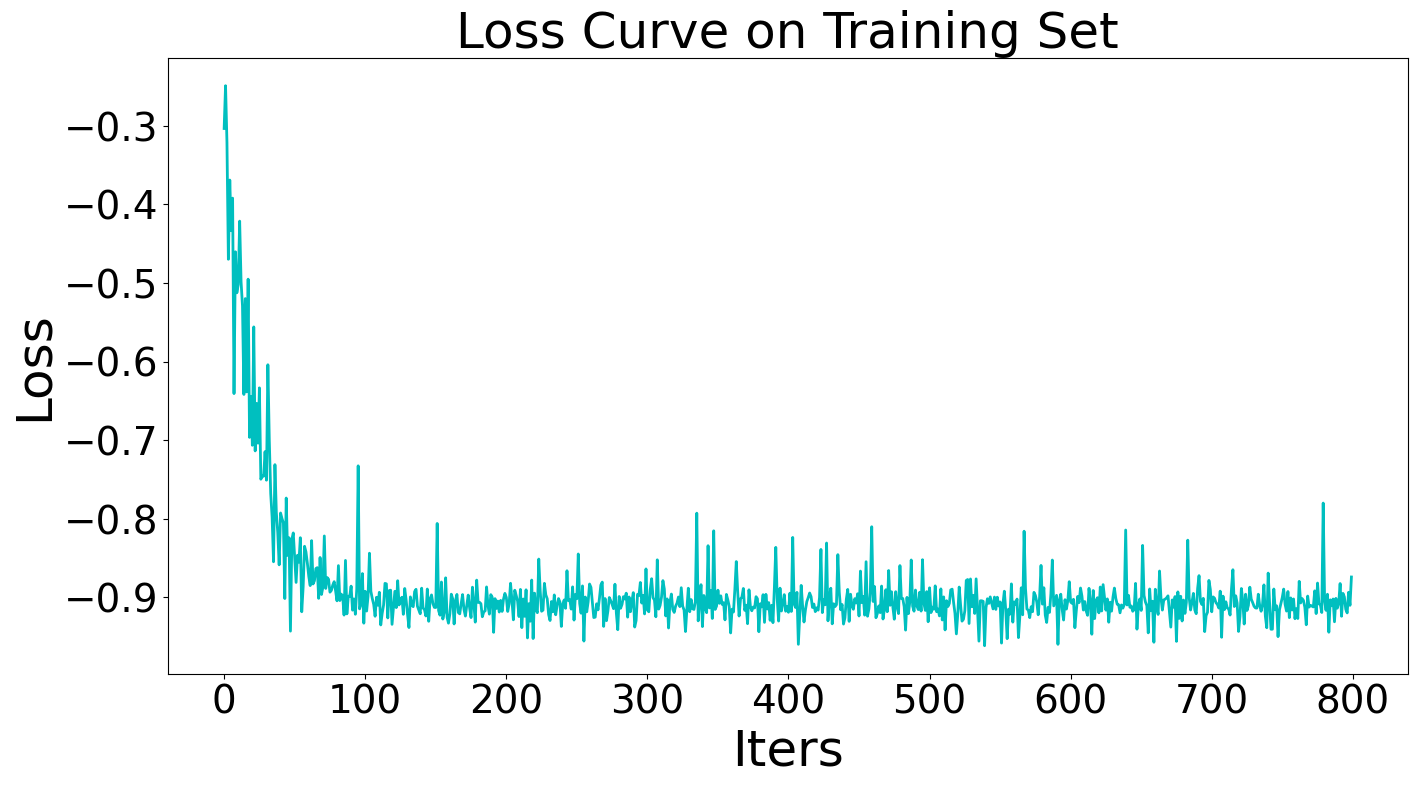

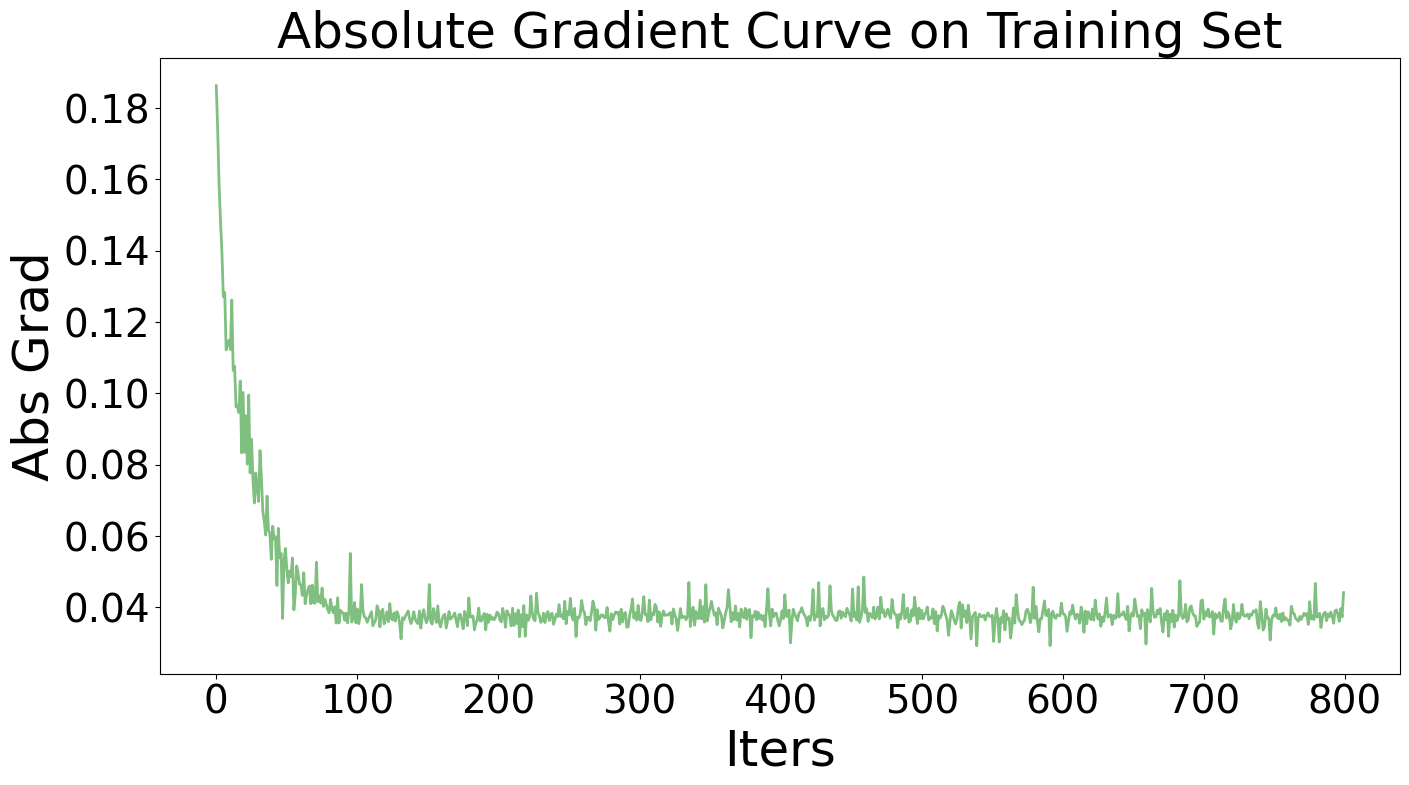

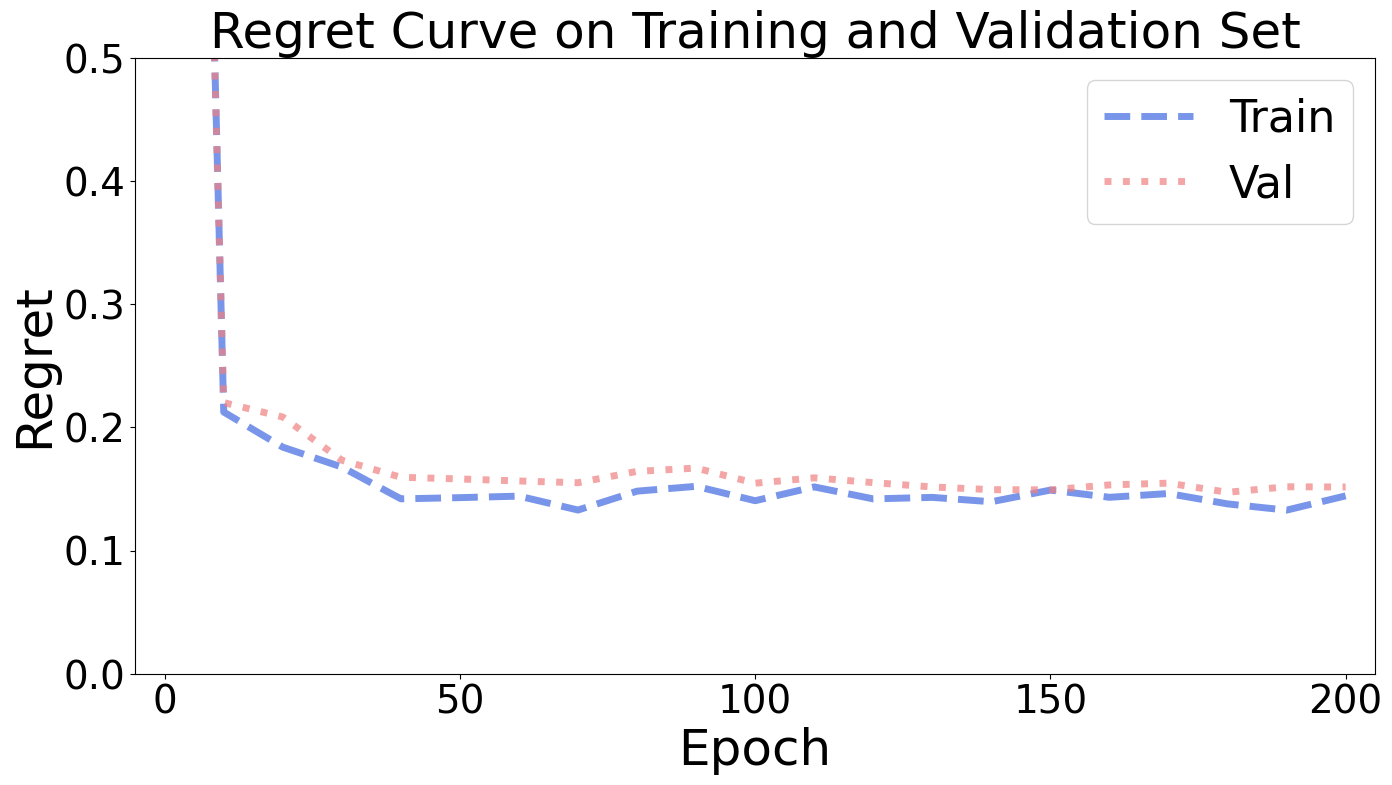

In [35]:
plot(loss_log, grad_log, regret_log_trn, regret_log_val, num_epochs, log_step)

###  Average Method with Cone Check

In [36]:
# init model
reg = LinearRegression()

In [37]:
from func import avgConeAlignedCosine
# init loss
ca_cos = avgConeAlignedCosine(optmodel, inner_ratio=0.4, check_cone=True, processes=8)

Num of cores: 8


In [38]:
lr = 1e-1
loss_log, grad_log, regret_log_trn, regret_log_val = pipeline(reg, forwardCAVE, ca_cos, lr, num_epochs, log_step,
                                                              loader_train, loader_val, loader_test)

  0%|                                                                                          | 0/200 [00:01<?, ?it/s]

Epoch   0, Train Regret: 198.6120%, Val Regret: 197.8650%


Epoch    9, Loss:  -0.8589:   5%|██▋                                                  | 10/200 [00:21<05:44,  1.81s/it]

Epoch  10, Train Regret:  21.4253%, Val Regret:  21.7524%


Epoch   19, Loss:  -0.8918:  10%|█████▎                                               | 20/200 [00:40<05:23,  1.80s/it]

Epoch  20, Train Regret:  18.7097%, Val Regret:  21.2207%


Epoch   29, Loss:  -0.9337:  15%|███████▉                                             | 30/200 [01:00<05:02,  1.78s/it]

Epoch  30, Train Regret:  16.7988%, Val Regret:  17.0484%


Epoch   39, Loss:  -0.9327:  20%|██████████▌                                          | 40/200 [01:19<04:44,  1.78s/it]

Epoch  40, Train Regret:  14.1162%, Val Regret:  15.9508%


Epoch   49, Loss:  -0.8950:  25%|█████████████▎                                       | 50/200 [01:38<04:28,  1.79s/it]

Epoch  50, Train Regret:  14.2537%, Val Regret:  15.8170%


Epoch   59, Loss:  -0.9367:  30%|███████████████▉                                     | 60/200 [01:58<04:11,  1.80s/it]

Epoch  60, Train Regret:  14.5506%, Val Regret:  15.6187%


Epoch   69, Loss:  -0.9411:  35%|██████████████████▌                                  | 70/200 [02:17<03:54,  1.81s/it]

Epoch  70, Train Regret:  13.3660%, Val Regret:  15.5163%


Epoch   79, Loss:  -0.9190:  40%|█████████████████████▏                               | 80/200 [02:36<03:33,  1.78s/it]

Epoch  80, Train Regret:  14.5101%, Val Regret:  16.2855%


Epoch   89, Loss:  -0.9452:  45%|███████████████████████▊                             | 90/200 [02:56<03:14,  1.77s/it]

Epoch  90, Train Regret:  15.0634%, Val Regret:  16.6393%


Epoch   99, Loss:  -0.9114:  50%|██████████████████████████                          | 100/200 [03:15<02:58,  1.78s/it]

Epoch 100, Train Regret:  14.1890%, Val Regret:  15.4397%


Epoch  109, Loss:  -0.9339:  55%|████████████████████████████▌                       | 110/200 [03:34<02:39,  1.77s/it]

Epoch 110, Train Regret:  15.2041%, Val Regret:  15.7021%


Epoch  119, Loss:  -0.8595:  60%|███████████████████████████████▏                    | 120/200 [03:53<02:21,  1.77s/it]

Epoch 120, Train Regret:  14.2355%, Val Regret:  15.4180%


Epoch  129, Loss:  -0.9464:  65%|█████████████████████████████████▊                  | 130/200 [04:13<02:06,  1.81s/it]

Epoch 130, Train Regret:  14.3364%, Val Regret:  15.0966%


Epoch  139, Loss:  -0.9314:  70%|████████████████████████████████████▍               | 140/200 [04:32<01:47,  1.79s/it]

Epoch 140, Train Regret:  13.8493%, Val Regret:  15.1816%


Epoch  149, Loss:  -0.8800:  75%|███████████████████████████████████████             | 150/200 [04:52<01:28,  1.77s/it]

Epoch 150, Train Regret:  14.7739%, Val Regret:  14.9170%


Epoch  159, Loss:  -0.8142:  80%|█████████████████████████████████████████▌          | 160/200 [05:11<01:11,  1.78s/it]

Epoch 160, Train Regret:  14.3697%, Val Regret:  15.3515%


Epoch  169, Loss:  -0.9300:  85%|████████████████████████████████████████████▏       | 170/200 [05:30<00:54,  1.81s/it]

Epoch 170, Train Regret:  14.5298%, Val Regret:  15.5086%


Epoch  179, Loss:  -0.9433:  90%|██████████████████████████████████████████████▊     | 180/200 [05:50<00:38,  1.95s/it]


Epoch 180, Train Regret:  13.7676%, Val Regret:  14.9883%

Early Stop!
Training Elapsed Time: 137.01 Sec

Evaluation:
Test Regret: 16.0682%
Test Elapsed Time: 8.21 Sec


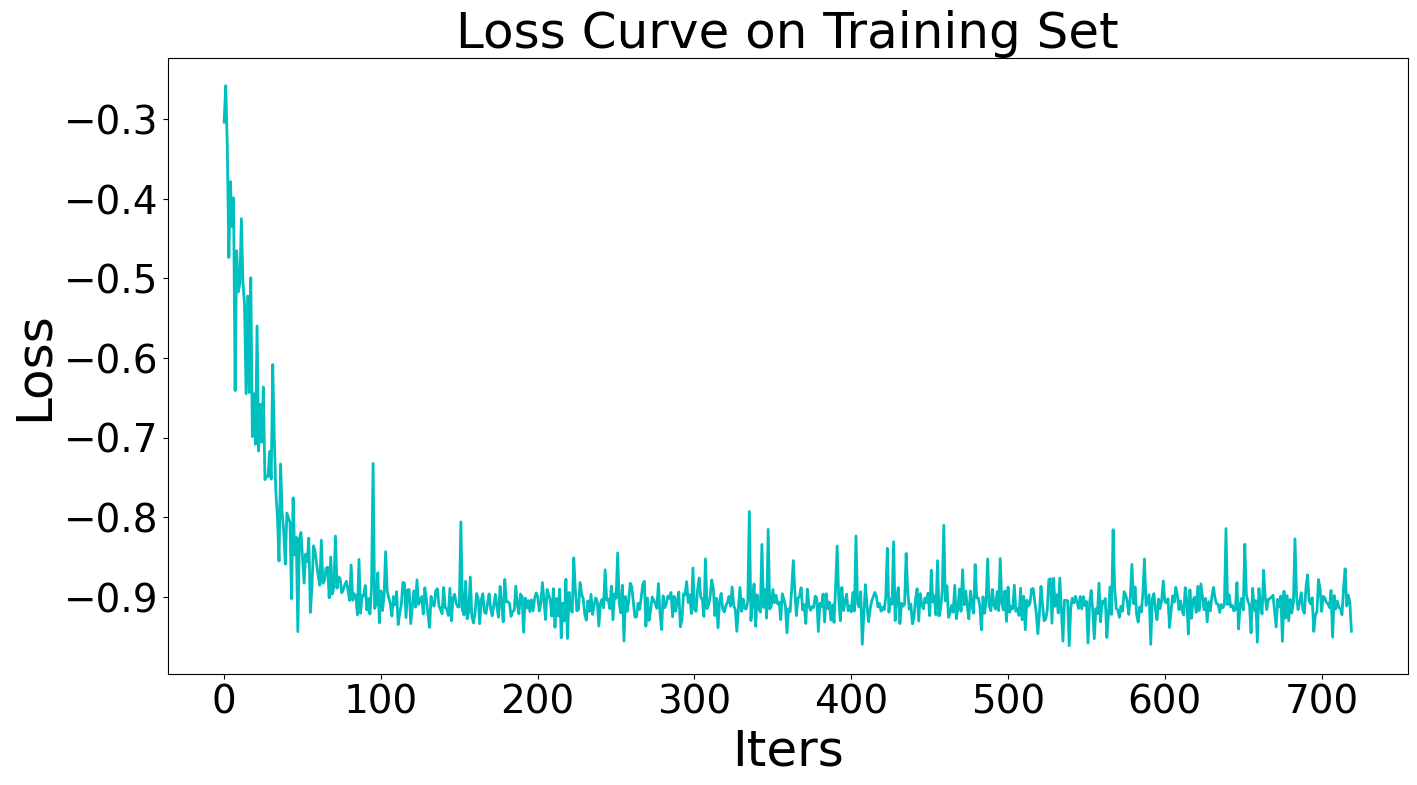

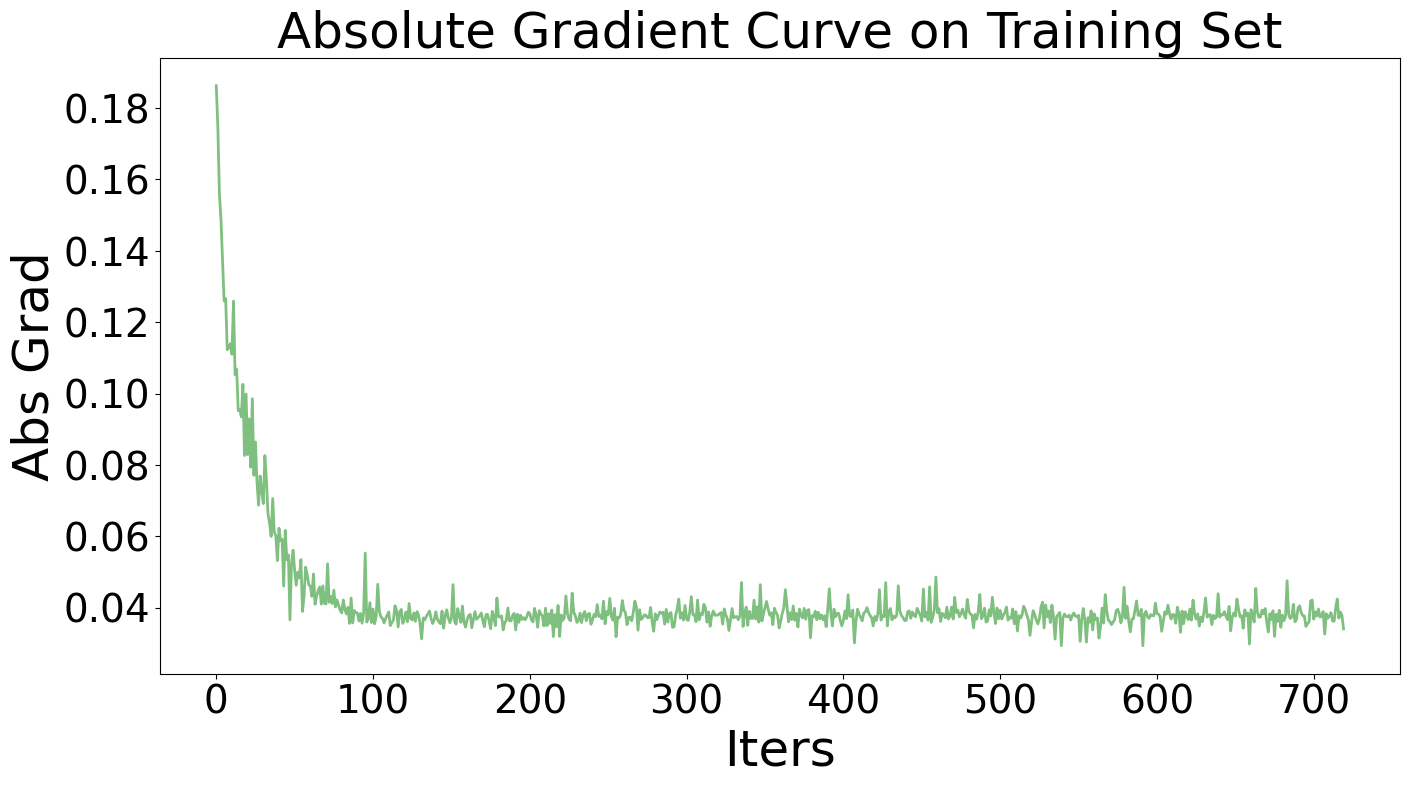

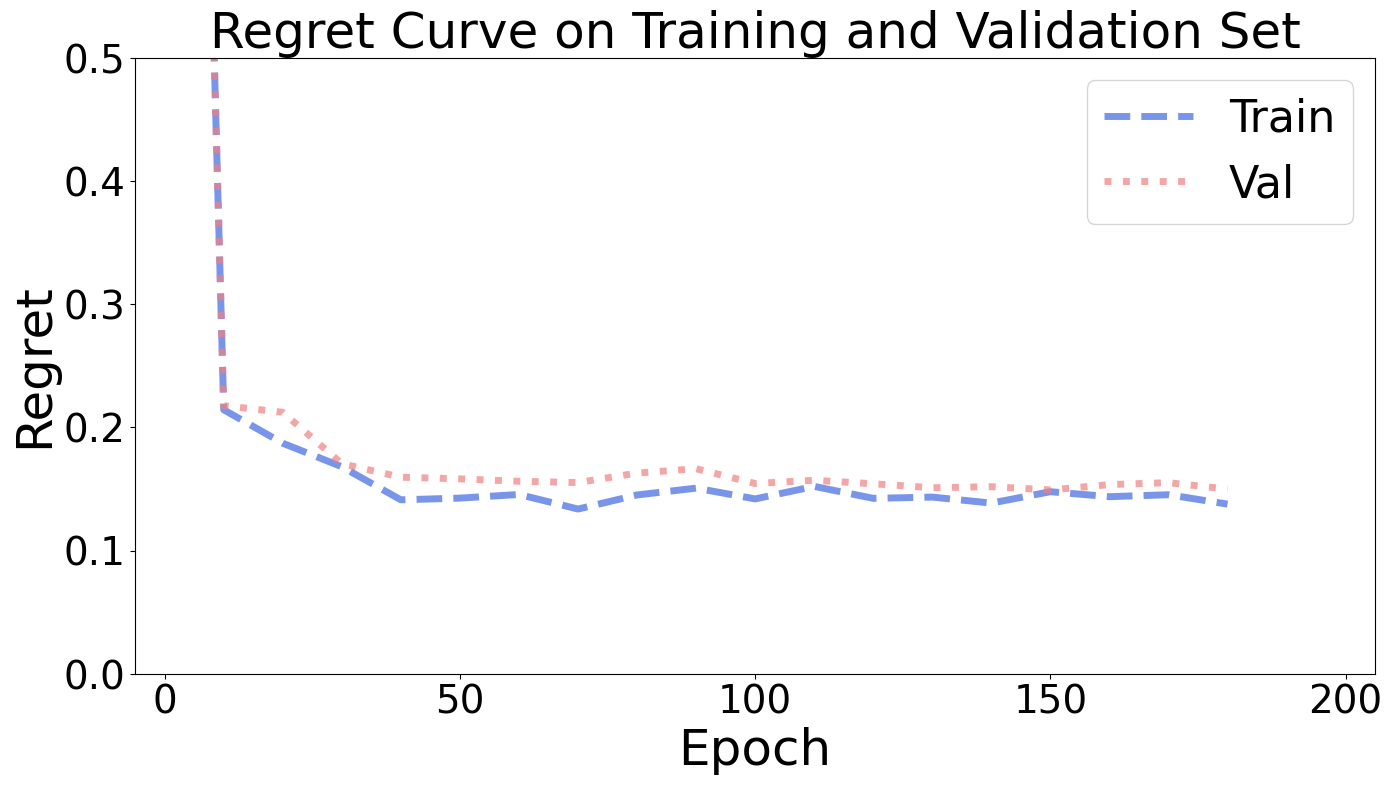

In [39]:
plot(loss_log, grad_log, regret_log_trn, regret_log_val, num_epochs, log_step)